# Movie Data Exploration -- Rotten Tomatoes (Text Data, Naive Bayes)

## Introduction

In this notebook, I'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" in my directory. I've also put a file "movies.dat" containing metadata for ~65,000 different movies.

Rotten Tomatoes is a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for last year's Revenant(http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

My objective is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, let's start out with some exploratory data analysis.

In [23]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

---

## Part 1: Descriptive analysis

Before beginning the "real" work, let's dig into the data a bit do see how the data is present. Loading the datasets and 
dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv', parse_dates = ['review_date']).dropna()
movies = pd.read_csv("movies.dat", delimiter='\t').dropna()

# skipping the missing attributes.
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

# converting the data types of the fetures into relevant values.
reviews['fresh'] = reviews['fresh'].map({'fresh':1, 'rotten':0})
# link, publication, quote, title, critic
reviews['critic'] = reviews['critic'].astype(str)
reviews['publication'] = reviews['publication'].astype(str)
reviews['title'] = reviews['title'].astype(str)

print("Reviews Data")
print(reviews.shape)
print(reviews.iloc[0,:])
print()
print("Movies data")
print(movies.shape)
print(movies.iloc[0,:])


reviews.dtypes

Reviews Data
(12718, 9)
critic                                               Derek Adams
fresh                                                          1
imdb                                                      114709
link           http://www.timeout.com/film/reviews/87745/toy-...
publication                                             Time Out
quote          So ingenious in concept, design and execution ...
review_date                                  2009-10-04 00:00:00
rtid                                                        9559
title                                                  Toy Story
Name: 0, dtype: object

Movies data
(8975, 21)
id                                                                        1
title                                                             Toy story
imdbID                                                               114709
spanishTitle                                           Toy story (juguetes)
imdbPictureURL            http://ia.medi

critic                 object
fresh                   int64
imdb                    int64
link                   object
publication            object
quote                  object
review_date    datetime64[ns]
rtid                    int64
title                  object
dtype: object

### 1.1: Basic features of the dataset

Laying out some generic questions:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [3]:
# enter your code below
print("Number of Unique reviews: ", reviews.quote.nunique())
print("Number of Unique reviewers: ", reviews.critic.nunique())
print("Number of Unique movies(reviews data set): ", reviews.title.nunique())
print("Number of Unique movies(Movies data set): ", movies.title.nunique())
print("Number of Unique Publications: ", reviews.publication.nunique())
print ("Number of reviews: %i" % len(reviews))

Number of Unique reviews:  12149
Number of Unique reviewers:  540
Number of Unique movies(reviews data set):  1715
Number of Unique movies(Movies data set):  8959
Number of Unique Publications:  64
Number of reviews: 12718


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, creating a histogram which shows the distribution of the number of reviews per reviewer. Setting the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scaling the y-axis to show the logarithm of (count of) the number of reviews.

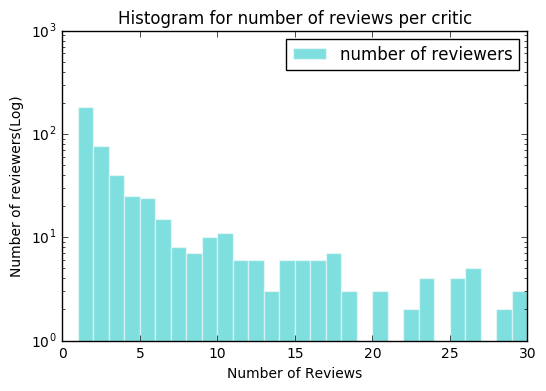

In [4]:
critics_df = pd.DataFrame(reviews.groupby('critic').count())
critics_df.reset_index(level=0, inplace=True)

# critics_df
plt.hist(critics_df.quote, range=[0,30], bins= 30, facecolor='c', edgecolor='white', label ="number of reviewers", alpha=0.5)
plt.xlim([0, 30])
plt.xlabel("Number of Reviews")
plt.ylabel('Number of reviewers(Log)')
plt.yscale('log', nonposy='clip')
plt.title('Histogram for number of reviews per critic')
plt.legend(loc="best")

### 1.3 Analysing few peculiar reviewers
Finding the 30 critics with the most reviews, and listing their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review


In [5]:
count_df = pd.DataFrame(reviews.groupby('critic')['critic'].count())
count_df.columns = ['count']

# getting the max and min review_date for every critic
min_df = pd.DataFrame(reviews.groupby('critic').min())
max_df = pd.DataFrame(reviews.groupby('critic').max())
min_df = pd.DataFrame(min_df.iloc[:,5])
max_df = pd.DataFrame(max_df.iloc[:,5])
min_df.columns = ['start_date']
max_df.columns = ['end_date']

min_df.reset_index(level=0, inplace =True)
max_df.reset_index(level=0, inplace =True)

publication = []

for i in range(len(count_df.index)):
    publication.append(reviews[reviews.critic == count_df.index[i]]['publication'].values[0])

count_df.reset_index(level=0, inplace=True)
count_df['publication'] = publication

#merging the above columns
date_df = pd.merge(min_df, max_df, on='critic')
critic_df = pd.merge(count_df, date_df, on='critic')

# SORTING THE NUMBER OF REVIEWS
top_30 = critic_df.sort_values(['count'], ascending=False).head(30)
top_30

top_30.drop('count', 1, inplace = True)
top_30.index = range(1,31)
top_30

,critic,publication,start_date,end_date
1,Roger Ebert,Chicago Sun-Times,2000-01-01,2013-06-11
2,James Berardinelli,ReelViews,1800-01-01,2012-02-07
3,Janet Maslin,New York Times,2000-01-01,2010-09-07
4,Variety Staff,Variety,2001-02-13,2012-08-15
5,Jonathan Rosenbaum,Chicago Reader,1988-07-11,2013-10-22
6,Desson Thomson,Washington Post,2000-01-01,2012-10-08
7,Geoff Andrew,Time Out,2005-08-11,2012-04-05
8,Dave Kehr,Chicago Reader,2000-01-01,2013-11-20
9,Kenneth Turan,Los Angeles Times,2000-01-01,2013-10-05
10,Mick LaSalle,San Francisco Chronicle,2000-01-01,2009-11-25


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [6]:
movies.head(2)
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(pd.to_numeric, errors='drop')
movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].apply(pd.to_numeric, errors = 'drop')
movies['rtAudienceRating'] = movies['rtAudienceRating'].apply(pd.to_numeric, errors= 'drop')
movies.dtypes

id                          int64
title                      object
imdbID                      int64
spanishTitle               object
imdbPictureURL             object
year                        int64
rtID                       object
rtAllCriticsRating        float64
rtAllCriticsNumReviews      int64
rtAllCriticsNumFresh       object
rtAllCriticsNumRotten      object
rtAllCriticsScore          object
rtTopCriticsRating         object
rtTopCriticsNumReviews     object
rtTopCriticsNumFresh       object
rtTopCriticsNumRotten      object
rtTopCriticsScore          object
rtAudienceRating          float64
rtAudienceNumRatings       object
rtAudienceScore            object
rtPictureURL               object
dtype: object

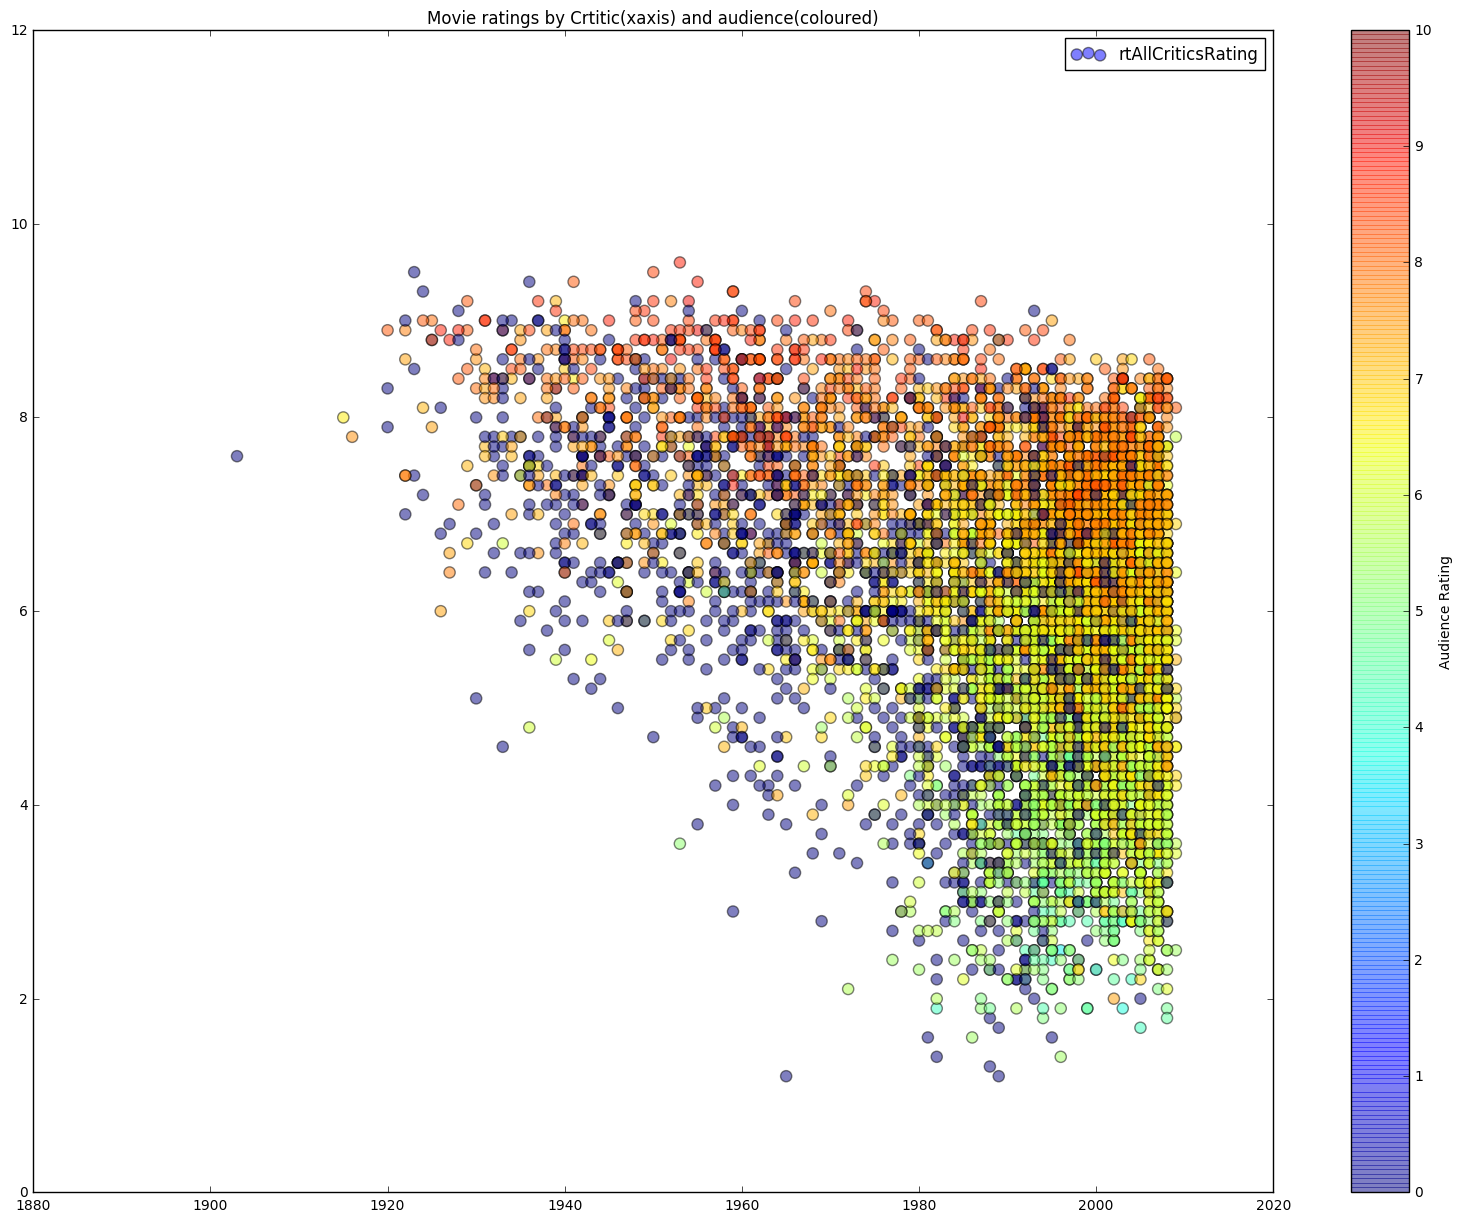

In [24]:
plt.figure(figsize=(20,15))

# drop movies with 0 rating
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(lambda x: x if x >0 else None)
sizeList = list(movies['rtAllCriticsNumReviews'].apply(lambda x: x*8 if x > 0 else x))
# color list for potraying audience ratings
colorList = list(movies['rtAudienceRating'].apply(lambda x: x*2))
sctr = plt.scatter(movies['year'], movies['rtAllCriticsRating'], c=colorList, s=65)
sctr.set_alpha(0.5)
plt.colorbar(label='Audience Rating')

year_df = pd.DataFrame(movies.groupby('year')['year'].count())
year_df.columns = ['count']
year_df['sumRating'] = movies.groupby('year')['rtAllCriticsRating'].sum()

year_df['avgRating'] = year_df['sumRating']/year_df['count']
year_df.reset_index(level=0, inplace =True)

year_df = year_df.dropna()
# Uncomment to plot a trend in average rating over the year
# plt.plot(year_df['year'], year_df['avgRating'], c='#6b00b3', linewidth=5.0, marker='o', label='Average rating')
plt.legend()
plt.title('Movie ratings by Crtitic(xaxis) and audience(coloured)')

    Scatter plot of Movies and their ratings.
    Every point here is a movie and its position with respect to the y axis quantifies the ratings awarded by the critic. While the color map potrays the audience ratings for the same movie. Blue(low) to Red(high)
    
---

In [8]:
year_df.head()

,year,count,sumRating,avgRating
0,1903,1,7.6,7.600
1,1915,1,8.0,8.000
2,1916,1,7.8,7.800
6,1920,4,25.1,6.275
8,1922,7,48.3,6.900


**Creating a scatter plot:**
As the amount of data here is huge, a scatter plot can often get messy. out first approach was to keep the size varying based in different features, which would give us an even more deeper insight into the values. On using the 'number of reviews' as size, teh scatter points were oberlapping with each other and therfore were discarded. ALthough this would ahve been a very good variable for knowing how credible can the ratings are.
Finally, teh size was kept constant and different intersting features we tried on color. Out of them audience rating was chosen.
As the colorbar on the right shows: blue, green, red correspond to lower, mid and higher ratings. traditionally we should observe the concentration of the plot to be similar. But, interstingly enough, we can observe blue point(lower ratings) through out the scatter plot and expecially for the movies which the critcs rated to be above 9. This shows how erratic and disparate are the audience ratings.

**Observations:**
On observing the scatter plot we can see that the number of ratings are increased by the year, and this is potrayed by the increase in density of the points towards the right end of the x-axis.
The line plot gives us a sense of change in the average rating. apart from some undulations we can observe that the ratings decrease iver the years.
This could be credited to the following reasons:
1. Increase in the number of reviews can cause the average to be much lower than when compared to lesser movies as the case in the previous years

2. The increase in the number of movies. Technically speaking as the number of movies increase, it becomes difficult to keep the quality to a top level. As the years progress majority of the movies are rated as 'mediocre' this decreases the average as well.

*Note: Additionally, another case could be that with the increase in number of movies, the critics give out a relative ratings for movies belonging to the same genre. in example: a 20th century animated movie could be great in the 80s - 90s but as they become increasingly common they 'uniqueness' does not facilitate a high rating.*

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print ("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Creating X input and Y output

Using the `reviews` dataframe to compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.

note: removing items with no reviews.

In [10]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
from sklearn.feature_extraction.text import CountVectorizer

def make_xy(reviews, vectorizer=None):
    if(vectorizer==None):
        vectorizer = CountVectorizer()
    
    rev_list = list(reviews.quote)
    vectorizer.fit(rev_list)
    X = vectorizer.transform(rev_list)
    Y = reviews.fresh.as_matrix()
    return X.toarray(), Y

X, Y = make_xy(reviews)

In [11]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly spliting the data into two groups: a training set and a validation set.

In [12]:
from sklearn.cross_validation import train_test_split

X_train,X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.33, random_state=90)

print("Train features & target")
print(X_train.shape)
print(Y_train.shape)
print()
print("Test features & target")
print(X_test.shape)
print(Y_test.shape)

Train features & target
(8521, 20267)
(8521,)

Test features & target
(4197, 20267)
(4197,)


### 2.3 Naive Bayes with `MultinomialNB`
Using the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) object. Noting the accuracy of this model on both the training and testing data.

In [13]:
from sklearn.naive_bayes import MultinomialNB

nv_model = MultinomialNB()
nv_model.fit(X_train, Y_train)

# call the fitted model fitted_model, for future reference:
fitted_model = nv_model

# Accuracy on the training model.
print("Accuracy on the Training set: ", nv_model.score(X_train, Y_train))

# Accuracy on the training model.
print("Accuracy on the Test set: ",nv_model.score(X_test, Y_test))

Accuracy on the Training set:  0.927590658373
Accuracy on the Test set:  0.778174886824


**Observations:**

This is one of those cases where the model performs really well on the training set(93%) but fails to emulate the same on the test set(78%). Usualy this comes out to be overfitting the training data too well and therfore, has scope for improvement. Crossvalidation may give us a morte reliable accuracy but the same cannot be said for an increase in the accuracy of the model itself.

---

## Part 3: Evaluation

### 3.1 Estimating the likelihood of our data

Given a fitted model, we can compute the log-likelihood of your data as a way to assess the performance of our model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of the training and testing data given our fitted model from part 2.

In [14]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test, Y_test)

-2329.8646555321711

### 3.2 Cross-Validation

This is where the log-likelihood is significant; for Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

The objective function we want to maximize is the log-likelihood of our data. We loop over many values of `alpha` and `min_df` to determine which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

In [15]:
from sklearn.cross_validation import KFold

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf


for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        # Performing 10-fold cross validation
        kf = KFold(X.shape[0], n_folds=10)
        loglike = 0
        
        for train,test in kf:
            X_train, X_test = X[train], X[test]
            Y_train, Y_test = Y[train], Y[test]
            
            fitted_model = MultinomialNB(alpha = alpha)
            fitted_model.fit(X_train, Y_train)
            loglike += log_likelihood(fitted_model, X_test, Y_test)
        
        loglike /=10
        
        if max_loglike < loglike:
            max_loglike = loglike
            best_alpha = alpha
            best_min_df = min_df

print("The best values of the hyperparameters are:")
print("Alpha = ", best_alpha)
print("Minimum Docment Frequency = ", best_min_df)
print("LogLikelihood = ", max_loglike)

The best values of the hyperparameters are:
Alpha =  5
Minimum Docment Frequency =  0.001
LogLikelihood =  -690.258421398


### 3.3 Putting it together

Now that the values for alpha and min_df that optimize the cross-validated log-likelihood are determined, we repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.

*Questions to observe?
1. Is the new model more or less accurate? 
2. Is overfitting better or worse?*

In [16]:
# Creating CountVectorizer
opt_vectorizer = CountVectorizer(min_df = best_min_df)

# Creating 'Bag of words'
X, Y = make_xy(reviews, opt_vectorizer)

# Train and Test split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.33, random_state=90)

# Fitting the naive Bayes model
cv_fitted_model = MultinomialNB(alpha = 5)
cv_fitted_model.fit(X_train, Y_train)

# Accuracy on the training model.
print("Accuracy on the Training set: ", cv_fitted_model.score(X_train, Y_train))

# Accuracy on the training model.
print("Accuracy on the Test set: ", cv_fitted_model.score(X_test, Y_test))

Accuracy on the Training set:  0.799319328717
Accuracy on the Test set:  0.748629973791


**Observations:**

Previous Accuracy: 78%

Current Accuracy:74%

The results here are very interesting.
With the help of Cross validation we have received a much better estimate of the accuracy, but the accuracy overall is reduced when compared to the previous implementation. Moreover, by reducing the log likelihood to a minumum estimate we have seen a decrease in overfitting of the model as well.

### 3.4 Alternative to log likelihood

It'll be good to know what happens if we tried this again using a function besides the log-likelihood -- for example, the classification accuracy?

In [17]:
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_score = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        # Performing 10-fold cross validation
        kf = KFold(X.shape[0], n_folds=10)
        score_test = 0
        score_train =0
        
        for train,test in kf:
            X_train, X_test = X[train], X[test]
            Y_train, Y_test = Y[train], Y[test]
            
            fitted_model = MultinomialNB(alpha = alpha)
            fitted_model.fit(X_train, Y_train)
            score_test += fitted_model.score(X_test, Y_test)
            score_train += fitted_model.score(X_train, Y_train)
        
        score_test /= 10
        score_train /= 10
        
        if max_score < score_test:
            max_score = score_test
            best_alpha = alpha
            best_min_df = min_df
            max_score_train = score_train

print("The best values of the hyperparameters are:")
print("Alpha = ", best_alpha)
print("Minimum Docment Frequency = ", best_min_df)
print("max score: ", max_score)
print("Training Score: ", max_score_train)

The best values of the hyperparameters are:
Alpha =  1
Minimum Docment Frequency =  1e-05
max score:  0.774020728491
Training Score:  0.922384733073


### 3.5 Interpretation

Now we use our classifier and the `vectorizer.get_feature_names` method to determine what words ebst predict a fresh or rotten review.
Printing the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word we also note the model's probability of freshness if the word appears one time.

In [18]:
# using the above optimum values of min_df = 0.01 and alpha=5 
vectorizer = CountVectorizer(min_df = 0.01, stop_words='english')
X, Y = make_xy(reviews, vectorizer)
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X,Y)

# getting the words/features
feature_words = pd.DataFrame(np.array(vectorizer.get_feature_names()))
feature_words.rename(columns={0:'words'}, inplace =True)

# creating a indentity matrix and calculating the porbability
identity_mat = np.identity(np.shape(feature_words)[0])
prob_prediction = fitted_model.predict_log_proba(identity_mat)

feature_words['rotten_prob'] = prob_prediction[:,0]
feature_words['fresh_prob'] = prob_prediction[:,1]

print("Using this we can see that there are no positive values to the log probability, so that's good")
print(feature_words[feature_words.rotten_prob > 0].any())

# sorting the list based on log probability

print ('Top 10 best predictors for rotten are:')
print (feature_words.sort_values('rotten_prob', ascending=False)[['words', 'rotten_prob']].head(10))
print ('\n')
print ('Top 10 best predictors for fresh are:')
print (feature_words.sort_values('fresh_prob', ascending=False)[['words', 'fresh_prob']].head(10))

Using this we can see that there are no positive values to the log probability, so that's good
words          False
rotten_prob    False
fresh_prob     False
dtype: bool
Top 10 best predictors for rotten are:
     words  rotten_prob
5      bad    -0.357209
71  really    -0.415645
43     isn    -0.539404
19   doesn    -0.564516
68    plot    -0.571401
78  series    -0.598581
75  script    -0.607127
26     far    -0.685177
48  little    -0.690000
28    feel    -0.694038


Top 10 best predictors for fresh are:
            words  fresh_prob
24   entertaining   -0.175835
25  entertainment   -0.188454
65    performance   -0.195673
6            best   -0.214756
3        american   -0.220391
93          years   -0.235448
36          great   -0.256622
91          world   -0.256918
66   performances   -0.258250
31            fun   -0.292145


**Observations**

On the tchnical aspect if out data consisted of only probabilities we would have only noticed 0s and 1s. But the results here are not much surprising because the top words that predict Fresh review have a positive tone. whereas the top words for negative reviews have a negative tone.
Bust the surprising insights is in the words:
*years*, *performance* for Fresh
&
*really*, *plot*, *script*

These words are mostly neutral and can be used for both fresh and rotten review.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  We now find 5 fresh and rotten reviews where our model performs particularly poorly and printing each review.

*Question's on Observations?
1. What do we notice about these mis-predictions? 
2. Naive Bayes classifiers assumes that every word affects the probability independently of other words. In what way is this a bad assumption?*

Also: Testing the model against this review example:

    "This movie is not remarkable, touching, or superb in any way"

In [19]:
# running the entire training into the classifier.
# recycling data from above.

# creating a prediction column in the original data frame
reviews['prediction'] = fitted_model.predict(X)
reviews['result'] = (reviews.prediction == reviews.fresh)

# assigning the log probability to each prediciton.
prediction_prob = fitted_model.predict_proba(X)
reviews['rotten_prob'] = prediction_prob[:,0]
reviews['fresh_prob'] = prediction_prob[:,1]

# reviews[reviews.result == False][['prediction', 'fresh', 'rotten_prob', 'fresh_prob']].head()

wrong_pred = pd.DataFrame(reviews[reviews.result == False])


pd.options.display.max_colwidth = 200
# False positive: Actual- 'Rotten'; Prediction- 'Fresh'
print("The worst 5 fresh reviews which were actually rotten are:")
print(wrong_pred.sort_values('fresh_prob', ascending = False)['quote'].head(5))

print()
print("*"*125)
print("*"*125)
print()

# False negative: Actual- 'fresh'; Prediction- 'Rotten'
print("The worst 5 rotten reviews which were actually fresh are:")
print(wrong_pred.sort_values('rotten_prob', ascending = False)['quote'].head(6))


The worst 5 fresh reviews which were actually rotten are:
2449        Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilience of the American dream.
11644    At best, it is fun. But "fun" is not an aesthetic experience: fun remains on the surface. I have nothing against the surface. But it belongs where it is and shouldn't be taken for anything else.
4133                                                                       The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.
8865                                                                                                                             ...it does not have a great script, great performances or great direction.
13406                               Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come 

In [20]:
#Calculating the class probability of the example review
fitted_model.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[ 0.38271304,  0.61728696]])

**Observations:**

Independent assumption is always a pitfall when there exists a corelation among different feaures.
*Consisdering the top 5 Falsly 'fresh' predicitons:*
    The top most reviews have words like 'best', 'great', and 'fun' in it but the negative words like 'not' are subdued. Intuitively, there's a good probability that a review is fresh if it has the words like fun and best.

*Considering the top 5 falsly 'rotten' predicitons*
    The same problem persists here in th sense if the frequency of the words like 'bad' have the same effect with the negative words. Even if there exists positive words like 'enthusiastic' will not be wighted hevily by the Naive bayes calssifier if it's ferquency is very low.
    
*For the new text:*
     The review is rotten, and the model obviously fails to predict it as rotten. It has the probability of predicting the review correctly 40% of the times, which is not the worst performance.